### Load Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py
import os

from PIL import Image



# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)


2024-04-26 15:21:59.340736: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 15:21:59.372892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 15:21:59.372921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 15:21:59.373860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 15:21:59.379462: I tensorflow/core/platform/cpu_feature_guar

### Load and preprocess data

In [2]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
# dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
total_items = len(images_np)
train_size = int(total_items * 0.95)
test_size = total_items - train_size 

    # Splitting the dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size) 


2024-04-26 15:22:05.366237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


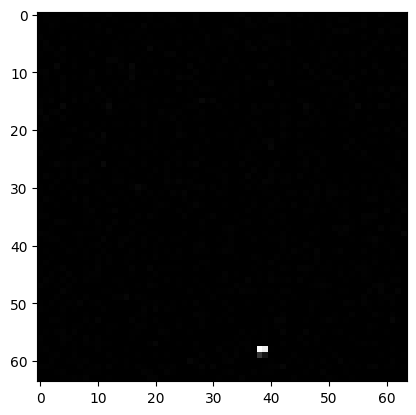

In [8]:
plt.imshow(images_np[1], cmap='gray')

### Model layout and definition

In [3]:
input_shape = (64,64,3)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)




model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'])    
num_epochs = 300

In [12]:
# model.fit(dataset, epochs=num_epochs)

In [4]:
# u= model.load_weights("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras")

In [4]:
# import tensorflow as tf
# from typing import List

# # import kornia
# import torch
# import torch.nn.functional as F


# def map01(mat):
#     return (mat - mat.min()) / (mat.max() - mat.min())


# def unravel_index(index, shape):
#     out = []
#     for dim in reversed(shape):
#         out.append(index % dim)
#         index = torch.div(index, dim, rounding_mode='floor')

#     return tuple(reversed(out))


# import tensorflow as tf

# def stitch_windows_tf(windows, k, cropx, cropy):
#     # Ensure windows is a TensorFlow tensor
#     windows = tf.convert_to_tensor(windows)

#     # Stitch the first row of windows
#     row0 = tf.concat([windows[0, 0][:-k, :-k]] +
#                      [win[:-k, k:-k] for win in windows[0, 1:-1]] +
#                      [windows[0, -1][:-k, k:]], axis=1)

#     rows = []

#     # Stitch the middle rows of windows
#     for r in range(1, windows.shape[0] - 1):
#         row_r = tf.concat([windows[r, 0][k:-k, :-k]] +
#                           [win[k:-k, k:-k] for win in windows[r, 1:-1]] +
#                           [windows[r, -1][k:-k, k:]], axis=1)
#         rows.append(row_r)

#     # Stitch the last row of windows
#     row_last = tf.concat([windows[-1, 0][k:, :-k]] +
#                          [win[k:, k:-k] for win in windows[-1, 1:-1]] +
#                          [windows[-1, -1][k:, k:]], axis=1)

#     # Combine all rows
#     final = tf.concat([row0] + rows + [row_last], axis=0)
    
#     # Crop to the original size if necessary
#     final = final[:cropx, :cropy]
    
#     return final


# import tensorflow as tf

# def connected_components_tf(image, num_iterations=100):
#     if not tf.is_tensor(image):
#         raise TypeError(f"Input type is not a tf.Tensor. Got: {type(image)}")
    
#     if not isinstance(num_iterations, int) or num_iterations < 1:
#         raise TypeError("Input num_iterations must be a positive integer.")
    
#     if len(image.shape) < 3 or image.shape[-3] != 1:
#         raise ValueError(f"Input image shape must be (*, 1, H, W). Got: {image.shape}")
    
#     # Reshape image to 2D if it's more than 3D
#     shape = tf.shape(image)
#     image = tf.reshape(image, [-1, shape[-2], shape[-3]])
    
#     # Create initial labels
#     B, H, W = image.shape
#     labels = tf.reshape(tf.range(B * H * W, dtype=image.dtype), [B, H, W])
#     mask = tf.equal(image, 1)
    
#     # Initialize labels as zero where mask is False
#     labels = tf.where(mask, labels, tf.zeros_like(labels))
    
#     for _ in range(num_iterations):
#         # Max pool current labels to simulate the dilation effect
#         labels = tf.expand_dims(labels, axis=3)  # Add a channel dimension
#         pooled_labels = tf.nn.max_pool2d(labels, ksize=3, strides=1, padding='SAME')
#         labels = tf.squeeze(pooled_labels, axis=[-1])  # Remove the channel dimension
#         labels = tf.where(mask, labels, tf.zeros_like(labels))
    
#     return tf.reshape(labels, shape)

# class LocatorTF:
#     def __init__(self, fastrcnn_model, process_stride=64, method='max', dark_threshold=20, locating_model=None,
#                  mode='static', **kwargs):
#         self.fastrcnn_model = fastrcnn_model
#         self.mode = mode
#         self.process_stride = process_stride
#         self.method = method
#         self.locating_model = locating_model
#         self.dark_threshold = dark_threshold
#         self.p_list = kwargs.get('p_list', [8, 6, 1.5, 1, 50])
#         self.meanADU = kwargs.get('meanADU', 241.0)
#         self.dynamic_thres = kwargs.get('dynamic_thres', True)
#         self.pretune_thresholding = kwargs.get('pretune_thresholding')




#     def model_tune(self, arr):
#         meanADU = self.meanADU * 4  # mean ADU * upsample_factor^2
#         offset = 0
#         limit = int(tf.reduce_sum(arr) / meanADU + offset)
#         arr_t = tf.cast(arr[None, None, ...] > 30, tf.float32)
        
#         # Assuming a custom implementation for connected components that returns a count
#         # since TensorFlow doesn't have a direct equivalent.
#         limit_cca = connected_components_tf(arr_t, num_iterations=10)
#         limit = max(limit_cca, limit)
#         limit = max(limit, 1)

#         self.fastrcnn_model.rpn._pre_nms_top_n = {'training': limit * self.p_list[0], 'testing': limit * self.p_list[0]}
#         self.fastrcnn_model.rpn._post_nms_top_n = {'training': limit * self.p_list[1],
#                                                    'testing': limit * self.p_list[1]}
#         self.fastrcnn_model.roi_heads.detections_per_img = int(limit * self.p_list[2])
#         # self.fastrcnn_model.roi_heads.score_thresh = self.p_list[3] / limit if limit < self.p_list[4] else 0
#         self.fastrcnn_model.roi_heads.score_thresh = self.p_list[3] / limit

#         self.fastrcnn_model.roi_heads.nms_thresh = 0.02  # smaller, delete more detections

#         if limit > (0.005 * arr.shape[0] * arr.shape[1]) and self.dynamic_thres:  # 0.002 is minimum for model13
#             self.dark_threshold = 0  # for image that not quite sparse, lift the pre-thresholding.




#     def images_to_window_lists(self, inputs):
#         outputs = []
#         maxs = []
#         mins = []
#         h, w = inputs.shape[1], inputs.shape[2]

#         # TensorFlow's way of defining the upsample layer
#         upsample = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')

#         if self.process_stride is None:
#             for image in inputs:
#                 image = tf.expand_dims(image, 0)  # Add batch dimension
#                 windows = upsample(image)
#                 outputs.extend(tf.reshape(windows, [-1, *windows.shape[2:]]))
#                 maxs.extend([tf.reduce_max(image)] * (windows.shape[1] * windows.shape[2]))
#                 mins.extend([tf.reduce_min(image)] * (windows.shape[1] * windows.shape[2]))
#         else:
#             # Asserts in TensorFlow work differently, and dynamic checks like this are less common,
#             # but you can still perform a check using tf.debugging.assert_positive, for example.
#             for image in inputs:
#                 # Pad the image if necessary. This section will need to be adapted based on how you wish to pad.
#                 # TensorFlow uses 'reflect' mode for similar behavior to your PyTorch code.
#                 # The calculation of 'pad' needs to be adapted to TensorFlow.
#                 pad_height = tf.math.floordiv(h, self.process_stride - 6) * (self.process_stride - 6) + self.process_stride
#                 pad_width = tf.math.floordiv(w, self.process_stride - 6) * (self.process_stride - 6) + self.process_stride

#                 image_padded = tf.pad(image, [[0, pad_height - h], [0, pad_width - w]], mode='REFLECT')

#                 # Splitting and upsampling the windows
#                 # TensorFlow doesn't have an unfold function, but we can achieve something similar with tf.image.extract_patches
#                 sizes = [1, self.process_stride, self.process_stride, 1]
#                 strides = [1, self.process_stride - 6, self.process_stride - 6, 1]
#                 rates = [1, 1, 1, 1]  # For dilation, not used here
#                 windows = tf.image.extract_patches(images=tf.expand_dims(image_padded, 0),
#                                                 sizes=sizes,
#                                                 strides=strides,
#                                                 rates=rates,
#                                                 padding='VALID')
#                 windows = tf.reshape(windows, [-1, self.process_stride, self.process_stride, inputs.shape[-1]])
#                 windows = upsample(windows)
#                 outputs.extend(tf.reshape(windows, [-1, *windows.shape[2:]]))
#                 maxs.extend([tf.reduce_max(image)] * (windows.shape[0] * windows.shape[1]))
#                 mins.extend([tf.reduce_min(image)] * (windows.shape[0] * windows.shape[1]))

#         # Note: Returning `windows.shape` directly after the loop doesn't make sense in this context,
#         # because `windows` would only refer to the last processed batch. You might want to collect
#         # these shapes in a list if needed for each image/window.
#         return outputs, maxs, mins

#     # Assuming `images_to_window_lists` and `model_tune` are adapted to TensorFlow
#     def predict_sequence(self, inputs):
#         counted_list = []
#         eventsize_all = []
#         inputs = tf.cast(inputs, tf.float32)
#         counted_images = tf.zeros_like(inputs)

#         image_cell_list, windowshape, maxs, mins = self.images_to_window_lists(inputs)
#         for i, image_cell in enumerate(image_cell_list):

#             if self.mode == 'dynamic_window':
#                 self.model_tune(image_cell)
#             elif self.mode == 'dynamic_frame':
#                 # Similar logic adapted for TensorFlow
#                 pass  # Fill in based on adapted `model_tune`
#             elif self.mode == 'static':
#                 # Ensure process_stride compatibility
#                 pass
#             else:
#                 raise ValueError("Use mode = 'dynamic_window', 'dynamic_frame', or 'static'.")

#             # Image cell thresholding and normalization
#             image_cell = tf.where(image_cell < self.dark_threshold, 0, image_cell)
#             image_cell_normalized = (image_cell - mins[i]) / (maxs[i] - mins[i])

#             # Model inference (adapt based on your TensorFlow model)
#             boxes = self.fastrcnn_model(image_cell_normalized[None, ...])[0]['boxes']

#             select = []
#             for row, value in enumerate(boxes):
#                 if 0 < (value[2] - value[0]) < 30 and 0 < (value[3] - value[1]) < 30:
#                     select.append(row)
#             select = torch.as_tensor(select, dtype=torch.int, device=self.device)
#             filtered_boxes = torch.index_select(boxes, 0, select)
#             filtered_boxes = filtered_boxes / 2.0
#             image_cell_ori = F.interpolate(image_cell_ori[None, None, ...], scale_factor=0.5, mode='nearest')[0, 0]
#             filtered, _, eventsize = self.locate(image_cell_ori, filtered_boxes)
#             counted_list.append(filtered[None, ...])  # [1,w,h]
#             eventsize_all = eventsize_all + eventsize

#         image_num = int(len(counted_list) / windowshape[0] / windowshape[1])
#         for index in range(image_num):
#             counted_cells = counted_list[
#                             index * windowshape[0] * windowshape[1]:(index + 1) * windowshape[0] * windowshape[1]]
#             counted_cells = torch.cat(counted_cells)
#             counted_cells = counted_cells.reshape(windowshape[0], windowshape[1], int(windowshape[2] / 2),
#                                                   int(windowshape[3] / 2))
#             counted_images[index] = stitch_windows_tf(counted_cells, k=3, cropx=inputs.shape[1], cropy=inputs.shape[2])

#         return counted_images, eventsize_all

        
    

#     def locate(self, image_array, boxes):
#         width = 10
#         filtered = tf.zeros_like(image_array)
#         boxes = tf.cast(tf.round(boxes), tf.int32)
#         coor = []
#         eventsize = []

#         for box in boxes:
#             xarea = image_array[box[1]:(box[3] + 1), box[0]:(box[2] + 1)]

#             # Padding logic adapted for TensorFlow
#             if xarea.shape[0] > (width + 1) or xarea.shape[1] > (width + 1):
#                 paddings = tf.constant([[1, width], [1, width]])
#                 patch = tf.pad(xarea, paddings, mode='CONSTANT')[:width + 2, :width + 2]
#             else:
#                 paddings = tf.constant([[1, width - xarea.shape[1] + 1], [1, width - xarea.shape[0] + 1]])
#                 patch = tf.pad(xarea, paddings, mode='CONSTANT')

#             if self.method == 'max':
#                 model_x, model_y = tf.unravel_index(tf.argmax(patch, axis=None), patch.shape)
#             elif self.method == 'binary_com':
#                 patch = tf.where(patch < 30, 0, 1)
#                 x = tf.range(0, patch.shape[0], dtype=tf.float32)
#                 y = tf.range(0, patch.shape[1], dtype=tf.float32)
#                 weights_x, weights_y = tf.meshgrid(x, y, indexing='ij')
#                 model_x = tf.math.round(tf.reduce_sum(patch * weights_x) / tf.reduce_sum(patch))
#                 model_y = tf.math.round(tf.reduce_sum(patch * weights_y) / tf.reduce_sum(patch))
#             elif self.method == 'com':
#                 x = tf.range(0, patch.shape[0], dtype=tf.float32)
#                 y = tf.range(0, patch.shape[1], dtype=tf.float32)
#                 weights_x, weights_y = tf.meshgrid(x, y, indexing='ij')
#                 model_x = tf.math.round(tf.reduce_sum(patch * weights_x) / tf.reduce_sum(patch))
#                 model_y = tf.math.round(tf.reduce_sum(patch * weights_y) / tf.reduce_sum(patch))
#             else:
#                 raise ValueError("Use 'max', 'com', or 'binary_com' to locate the entry position.")

#             cx = model_x + box[1] - 1
#             cy = model_y + box[0] - 1

#             if cx >= image_array.shape[0] or cy >= image_array.shape[1] or cx < 0 or cy < 0:
#                 continue

#             coor.append([cx, cy])
#             eventsize.append(tf.reduce_sum(tf.cast(patch > 20, tf.int32)).numpy())

#         coords = tf.cast(coor, tf.int32)
#         for point in coords:
#             filtered = tf.tensor_scatter_nd_add(filtered, [point], [1])

#         return filtered, coords, eventsize


In [18]:
# import tensorflow as tf

# # Load the trained model
# model_path = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras"  # Path to the trained model file
# model = tf.keras.models.load_model(model_path)

# # We have a trained model, now let's proceed with the usage within the LocatorTF class.
# # Let's mock the LocatorTF class based on the user's previous context

# class LocatorTF:
#     def __init__(self, model):
#         self.model = model

#     def predict_sequence(self, dataset):
#         # For simplicity, let's just use the model to predict the first batch of the dataset
#         for images_batch, _ in dataset.take(1):  # Take first batch
#             the_probabilities, the_boxes = self.model.predict(images_batch)
#             print("Predictions:")
#             print("Probabilities shape:", probabilities.shape)
#             print("Boxes shape:", boxes.shape)
#             # For now, we'll just print the shapes. In a real scenario, you would process this output further.
#             return the_probabilities, the_boxes

# # Assuming the datasets have been created following the user's code:
# # test_dataset = test_dataset.batch(batch_size)

# # Instantiate the LocatorTF with the trained model
# locator = LocatorTF(model)

# # Use the LocatorTF class to predict
# the_probabilities, the_boxes = locator.predict_sequence(train_dataset)

# # This example is for illustration. The actual processing and usage will depend on the task at hand.
# # Now you would typically process 'probabilities' and 'boxes' to interpret the model's predictions.
# # In a real-world scenario, you would likely perform additional steps such as non-maximum suppression on the box predictions.



In [6]:
# import tensorflow as tf

# # Load the trained model
# model_path = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras"  # Path to the trained model file
# loadmodel = tf.keras.models.load_model(model_path)

# # We have a trained model, now let's proceed with the usage within the LocatorTF class.
# # Let's mock the LocatorTF class based on the user's previous context

# class LocatorTF:
#     def __init__(self, model):
#         self.model = model

#     def predict_sequence(self, dataset):
#         dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
#         # dataset = dataset.batch(4000)
#         test_dataset = dataset.skip(train_size)
#         # test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
#         test_dataset = test_dataset.batch(test_size)
#         # train_dataset = dataset.take(train_size)
#         # # train_dataset = train_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
#         # train_dataset = train_dataset.batch(train_size)
#         inputs,targets = next(iter(test_dataset))
#         output =loadmodel.predict(inputs)
#         the_probabilities = output[0]
#         the_boxes = output[1]
#         # For now, we'll just print the shapes. In a real scenario, you would process this output further.
#         return the_probabilities, the_boxes

# # Assuming the datasets have been created following the user's code:
# # test_dataset = test_dataset.batch(batch_size)

# # Instantiate the LocatorTF with the trained model
# locator = LocatorTF(loadmodel)

# # Use the LocatorTF class to predict
# the_probabilities, the_boxes = locator.predict_sequence(test_dataset)

# # This example is for illustration. The actual processing and usage will depend on the task at hand.
# # Now you would typically process 'probabilities' and 'boxes' to interpret the model's predictions.
# # In a real-world scenario, you would likely perform additional steps such as non-maximum suppression on the box predictions.



2024-04-23 21:15:13.311159: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-23 21:15:13.399416: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


15/16 [===========================>..] - ETA: 0s

2024-04-23 21:15:13.734032: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


16/16 [==============================] - 1s 21ms/step


### Load saved weights

In [4]:
loadmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras")

In [13]:
# model.fit(train_dataset, epochs=num_epochs)

In [16]:
# saved = tf.keras.models.save_model(loadmodel, "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras")

In [5]:
# loadedmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel4variant.keras")

### Post Training processing for furthur analysis

prediction

In [5]:

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
# # dataset = dataset.batch(4000)
# test_dataset = dataset.skip(train_size)
# # test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
# test_dataset = test_dataset.batch(test_size)
train_dataset = dataset.take(train_size)
# train_dataset = train_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(train_size)
inputs,targets = next(iter(train_dataset))
output =loadmodel.predict(inputs)

2024-04-26 15:22:31.238397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-26 15:22:31.326700: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 15/297 [>.............................] - ETA: 2s

2024-04-26 15:22:31.655534: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


297/297 [==============================] - 3s 9ms/step


evaluation

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
# dataset = dataset.batch(4000)
test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(test_size)
# inputs,targets = next(iter(test_dataset))
loadmodel.evaluate(test_dataset)

1/1 [==============================] - 5s 5s/step - loss: 0.0108 - x_prob_reshape_loss: 3.8639e-04 - x_boxes_reshape_loss: 0.0104 - x_prob_reshape_x_prob_reshape_x_prob_reshape_x_prob_reshape_accuracy: 1.0000


[0.0107931112870574,
 0.0003863875172100961,
 0.01040672417730093,
 0.9999785423278809]

Manual Loss calculation for verification

In [61]:
import tensorflow as tf

# r = np.random.randint(0,2000)
tensor1 = tf.constant(targets['x_boxes_reshape'][:,0,:,:], dtype=tf.float64) 

tensor2 = tf.constant(output[1][:,0,:,:], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()      
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())

MSE Loss: 0.01066310577196704


In [25]:
output[1][1,0,:,:]*64

array([[5.8196449e+01, 3.9055347e+01, 5.8878864e+01, 4.0044167e+01],
       [3.5207322e-01, 2.9732585e-01, 3.7346262e-01, 3.0226326e-01],
       [3.8188636e-01, 1.8726489e-01, 4.0640071e-01, 1.9325678e-01],
       ...,
       [6.6236017e-04, 5.8315234e-04, 4.3470500e-04, 1.1467851e-03],
       [6.2885071e-04, 5.5858173e-04, 5.7572121e-04, 5.3734903e-04],
       [6.9829030e-04, 1.3044660e-03, 4.4523229e-04, 1.7118002e-03]],
      dtype=float32)

In [24]:
targets['x_boxes_reshape'][1,0,:,:]*64

<tf.Tensor: shape=(280, 4), dtype=float64, numpy=
array([[58., 38., 59., 39.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])>

In [21]:
import numpy as np

def apply_threshold(bboxes):
    # Setting values less than 1 to zero and keeping others unchanged
    return np.where(bboxes < 1, 0, bboxes)

# Example ground truth and predicted bounding boxes
predictions = np.array([
    [39.8903408, 24.773323, 39.454777, 25.82823],
    [0.40461713, 0.2488891, 0.44437495, 0.2451111],
    [0.4801518, 0.56913036, 0.52614892, 0.60166949],
    [0.00044191495, 0.0005460676, 0.00068218674, 0.00090827933],
    [0.00040864121, 0.00038058122, 0.00060208299, 0.00024521281],
    [0.00052764977, 0.00058524718, 0.0002075122, 0.0010586288]
])

ground_truth = np.array([
    [39, 24, 39, 25],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

# Applying the function
ground_truth_processed = apply_threshold(ground_truth)
predictions_processed = apply_threshold(predictions)

# Display the results
print("Processed Ground Truth:\n", ground_truth_processed)
print("Processed Predictions:\n", predictions_processed)


Processed Ground Truth:
 [[39 24 39 25]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Processed Predictions:
 [[39.8903408 24.773323  39.454777  25.82823  ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.       ]]


In [19]:
# import numpy as np
# from scipy.ndimage import label, find_objects, center_of_mass
# import matplotlib.pyplot as plt

# def create_binary_mask(bboxes, image_shape):
#     masks = np.zeros((len(bboxes), image_shape[0], image_shape[1]), dtype=np.uint8)
#     for i, (x_min, y_min, x_max, y_max) in enumerate(bboxes):
#         if x_max > x_min and y_max > y_min:  # Ensure bounding box is valid
#             x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
#             masks[i, y_min:y_max, x_min:x_max] = 1
#     return masks

# def connected_component_properties(masks):
#     properties = []
#     for mask in masks:
#         labeled_mask, num_features = label(mask)
#         objects = find_objects(labeled_mask)
#         for i in range(num_features):
#             region = labeled_mask[objects[i]]
#             area = np.sum(region > 0)
#             centroid = center_of_mass(region)
#             properties.append({
#                 'label_mask': labeled_mask,
#                 'area': area,
#                 'bounding_box': objects[i],
#                 'centroid': centroid
#             })
#     return properties

# def plot_components(properties):
#     fig, axs = plt.subplots(len(properties), 1, figsize=(5, 5 * len(properties)))
#     if len(properties) == 1:
#         axs = [axs]  # Make it iterable if only one subplot
#     for ax, prop in zip(axs, properties):
#         ax.imshow(prop['label_mask'], cmap='hot')
#         bbox = prop['bounding_box']
#         rect = plt.Rectangle((bbox[1].start, bbox[0].start), bbox[1].stop-bbox[1].start, bbox[0].stop-bbox[0].start, linewidth=1, edgecolor='b', facecolor='none')
#         ax.add_patch(rect)
#         ax.scatter(*prop['centroid'][::-1], color='g')  # reverse centroid coordinates for plotting
#         ax.set_title(f"Area: {prop['area']}, Centroid: {prop['centroid']}")
#     plt.tight_layout()
#     plt.show()

# # Example usage:
# image_dimensions = (64, 64)
# ground_truth_bboxes = np.array([[39.8903408, 24.773323, 49.454777, 35.82823]])  # Filtered and adjusted to your array
# masks = create_binary_mask(ground_truth_bboxes, image_dimensions)
# properties = connected_component_properties(masks)
# plot_components(properties)


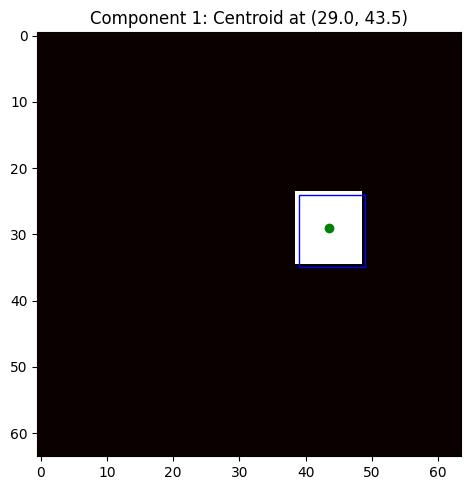

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, center_of_mass

# Provided bounding box data
bboxes = np.array([
    [39, 24, 39+10, 25+10],  # adjusted to ensure it's within the image size (64x64)
])

# Define image dimensions
image_dimensions = (64, 64)

# Function to create binary masks
def create_binary_mask(bboxes, image_shape):
    masks = np.zeros((len(bboxes), image_shape[0], image_shape[1]), dtype=np.uint8)
    for i, (x_min, y_min, x_max, y_max) in enumerate(bboxes):
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        masks[i, y_min:y_max, x_min:x_max] = 1
    return masks

# Function to extract properties and visualize
def visualize_components(masks):
    fig, axs = plt.subplots(len(masks), 1, figsize=(5, 5 * len(masks)))
    if len(masks) == 1:
        axs = [axs]  # Make it iterable if only one subplot
    for ax, mask in zip(axs, masks):
        labeled_mask, num_features = label(mask)
        ax.imshow(labeled_mask, cmap='hot')
        for i, slice_tuple in enumerate(find_objects(labeled_mask)):
            centroid = center_of_mass(mask, labels=labeled_mask, index=i+1)
            rect = plt.Rectangle((slice_tuple[1].start, slice_tuple[0].start), slice_tuple[1].stop - slice_tuple[1].start, slice_tuple[0].stop - slice_tuple[0].start, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
            ax.scatter(centroid[1], centroid[0], color='g')  # centroid plotting
            ax.set_title(f"Component {i+1}: Centroid at {centroid}")
    plt.tight_layout()
    plt.show()

# Create binary masks and visualize
masks = create_binary_mask(bboxes, image_dimensions)
visualize_components(masks)


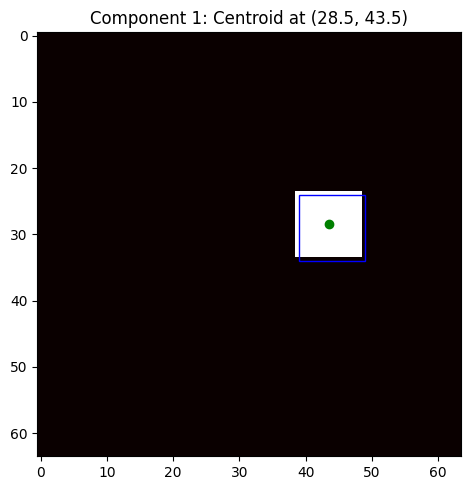

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, center_of_mass

# Hypothetical valid bounding boxes from ground truth
ground_truth_bboxes = np.array([
    [39, 24, 49, 34]  # Adjusted bounding box to fit within image dimensions and considered valid
])

# Define image dimensions
image_dimensions = (64, 64)

# Function to create binary masks
def create_binary_mask(bboxes, image_shape):
    masks = np.zeros((len(bboxes), image_shape[0], image_shape[1]), dtype=np.uint8)
    for i, (x_min, y_min, x_max, y_max) in enumerate(bboxes):
        x_min, y_min, x_max, y_max = map(int, [x_min, y_min, x_max, y_max])
        masks[i, y_min:y_max, x_min:x_max] = 1
    return masks

# Function to extract properties and visualize
def visualize_components(masks):
    fig, axs = plt.subplots(len(masks), 1, figsize=(5, 5 * len(masks)))
    if len(masks) == 1:
        axs = [axs]  # Make it iterable if only one subplot
    for ax, mask in zip(axs, masks):
        labeled_mask, num_features = label(mask)
        ax.imshow(labeled_mask, cmap='hot')
        for i, slice_tuple in enumerate(find_objects(labeled_mask)):
            centroid = center_of_mass(mask, labels=labeled_mask, index=i+1)
            rect = plt.Rectangle((slice_tuple[1].start, slice_tuple[0].start), slice_tuple[1].stop - slice_tuple[1].start, slice_tuple[0].stop - slice_tuple[0].start, linewidth=1, edgecolor='b', facecolor='none')
            ax.add_patch(rect)
            ax.scatter(centroid[1], centroid[0], color='g')  # centroid plotting
            ax.set_title(f"Component {i+1}: Centroid at {centroid}")
    plt.tight_layout()
    plt.show()

# Create binary masks for ground truth and visualize
ground_truth_masks = create_binary_mask(ground_truth_bboxes, image_dimensions)
visualize_components(ground_truth_masks)


In [43]:
# import numpy as np

# def calculate_iou(box1, box2):
#     """Calculate Intersection over Union (IoU) between two bounding boxes."""
#     y1_inter = max(box1[0], box2[0])
#     x1_inter = max(box1[1], box2[1])
#     y2_inter = min(box1[2], box2[2])
#     x2_inter = min(box1[3], box2[3])
#     inter_area = max(0, y2_inter - y1_inter) * max(0, x2_inter - x1_inter)
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
#     union_area = box1_area + box2_area - inter_area
#     return inter_area / union_area if union_area else 0

# def calculate_mae(predictions, ground_truths):
#     """Calculate Mean Absolute Error (MAE) for bounding box predictions."""
#     errors = []
#     for pred, true in zip(predictions, ground_truths):
#         error = np.abs(pred - true)
#         errors.append(error)
#     mae = np.mean(errors)
#     return mae

# def calculate_metrics(predictions, ground_truths, iou_threshold=0.5):
#     """Calculate MAE, IoU, precision, recall, and F1 score."""
#     ious = []
#     tp = 0  # True positives
#     fp = 0  # False positives
#     fn = 0  # False negatives

#     for pred, true in zip(predictions, ground_truths):
#         iou = calculate_iou(pred, true)
#         ious.append(iou)

#         if iou >= iou_threshold:
#             tp += 1
#         else:
#             fp += 1
#             fn += 1

#     mae = calculate_mae(predictions, ground_truths)
#     average_iou = np.mean(ious)
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#     f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

#     return mae, average_iou, precision, recall, f1

# # Usage:
# #Assuming 'predicted_boxes' and 'ground_truth_boxes' are numpy arrays of shape (n, 4)
# m = np.random.randint(0,10000)
# mae, average_iou, precision, recall, f1 = calculate_metrics(output[1][m,0,:,:], targets['x_boxes_reshape'][m,0,:,:])

# #Print results
# print(f"MAE: {mae}, Average IoU: {average_iou}")
# print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")


### Visualisation of Predictions Against Labels

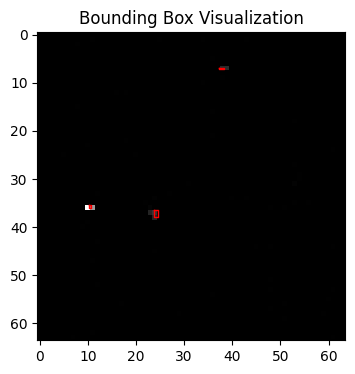

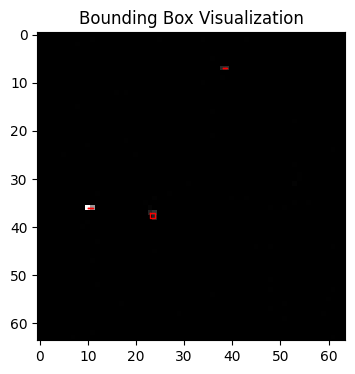

In [72]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.1):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=1, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,500)
# probabilities = tf.convert_to_tensor(output[0][t,:])
# t = 590
visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]),tf.convert_to_tensor(output[0][t,0,:,:]), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##groundtruth


In [73]:
output[1][t,0,:,:]

array([[5.6865549e-01, 3.7100157e-01, 5.9229678e-01, 3.8467100e-01],
       [1.0892609e-01, 5.8329308e-01, 1.1165814e-01, 5.9875888e-01],
       [5.5372411e-01, 1.5909961e-01, 5.6380141e-01, 1.6767269e-01],
       ...,
       [1.3300514e-06, 2.6311766e-06, 2.0211976e-06, 2.7679430e-06],
       [2.2027104e-06, 1.8676935e-06, 2.2467675e-06, 1.3071266e-06],
       [1.3012919e-06, 2.1325980e-06, 8.2916580e-07, 3.2145790e-06]],
      dtype=float32)

In [ ]:
# Assuming you have two lists, one for predictions and one for ground truth data:
predictions_list = [
    [[7.54326344e-01, 1.49682328e-01, 7.62333751e-01, 1.59394965e-01],
       [2.22115651e-01, 1.93735495e-01, 2.33741671e-01, 2.13580534e-01],
       [9.56069708e-01, 1.23659424e-01, 9.60171342e-01, 1.29140362e-01],
       ...,
       [2.63212019e-06, 1.80306131e-06, 1.15021669e-06, 2.25204258e-06],
       [9.09670121e-07, 9.65922254e-07, 1.00482930e-06, 4.87556463e-07],
       [1.06455207e-06, 5.36624214e-07, 5.92225149e-07, 1.51485767e-06]],[[5.6865549e-01, 3.7100157e-01, 5.9229678e-01, 3.8467100e-01],
       [1.0892609e-01, 5.8329308e-01, 1.1165814e-01, 5.9875888e-01],
       [5.5372411e-01, 1.5909961e-01, 5.6380141e-01, 1.6767269e-01],
       ...,
       [1.3300514e-06, 2.6311766e-06, 2.0211976e-06, 2.7679430e-06],
       [2.2027104e-06, 1.8676935e-06, 2.2467675e-06, 1.3071266e-06],
       [1.3012919e-06, 2.1325980e-06, 8.2916580e-07, 3.2145790e-06]]
]

ground_truth_list = [
    [[0.765625, 0.140625, 0.765625, 0.15625 ],
       [0.21875 , 0.203125, 0.234375, 0.21875 ],
       [0.953125, 0.125   , 0.96875 , 0.125   ],
       ...,
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]],[[0.578125, 0.359375, 0.59375 , 0.375   ],
       [0.109375, 0.59375 , 0.109375, 0.609375],
       [0.5625  , 0.15625 , 0.5625  , 0.171875],
       ...,
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]]
]

# Make sure that predictions_list[i] corresponds to ground_truth_list[i] for all i


In [74]:
targets['x_boxes_reshape'][t,0,:,:]

<tf.Tensor: shape=(280, 4), dtype=float64, numpy=
array([[0.578125, 0.359375, 0.59375 , 0.375   ],
       [0.109375, 0.59375 , 0.109375, 0.609375],
       [0.5625  , 0.15625 , 0.5625  , 0.171875],
       ...,
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]])>

In [63]:
boxes_np[t,0,:,:]

<tf.Tensor: shape=(280, 4), dtype=float64, numpy=
array([[0.765625, 0.140625, 0.765625, 0.15625 ],
       [0.21875 , 0.203125, 0.234375, 0.21875 ],
       [0.953125, 0.125   , 0.96875 , 0.125   ],
       ...,
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , 0.      ]])>

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
file_path = '/mnt/data/image.png'
image = cv2.imread(file_path)

# Convert the image to grayscale as the bounding boxes seem to be one color
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Now we split the image in half, the left side is predictions, right side is ground truth
midpoint = gray_image.shape[1] // 2
left_image = gray_image[:, :midpoint]
right_image = gray_image[:, midpoint:]

# Threshold the images to binary to find the bounding boxes
_, thresh_left = cv2.threshold(left_image, 1, 255, cv2.THRESH_BINARY)
_, thresh_right = cv2.threshold(right_image, 1, 255, cv2.THRESH_BINARY)

# Find contours which corresponds to the bounding boxes
contours_left, _ = cv2.findContours(thresh_left, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_right, _ = cv2.findContours(thresh_right, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to extract the bounding box from contours
def get_bounding_boxes(contours):
    bounding_boxes = []
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)
        # Append as a tuple
        bounding_boxes.append((x, y, w, h))
    return bounding_boxes

# Get the bounding boxes for predictions and ground truth
bounding_boxes_left = get_bounding_boxes(contours_left)
bounding_boxes_right = get_bounding_boxes(contours_right)

bounding_boxes_left, bounding_boxes_right


### Model Evaluation

1) Create Binary masks

In [15]:
# # import numpy as np

# def create_binary_mask_from_boxes(boxes, image_shape):
#     binary_mask = np.zeros(image_shape[:2], dtype=np.uint8)  # assuming image_shape is (height, width)
#     for box in boxes:
#         # Scale the box coordinates to the image size
#         x_min, y_min, x_max, y_max = box
#         x_min = int(x_min * image_shape[1])
#         x_max = int(x_max * image_shape[1])
#         y_min = int(y_min * image_shape[0])
#         y_max = int(y_max * image_shape[0])
#         binary_mask[y_min:y_max, x_min:x_max] = 1
#     return binary_mask

# # Assume 'output' is your model prediction output and has a shape (N, 1, num_boxes, 4)
# # Let's also assume 'output[0]' contains the confidence scores, and we only take boxes with confidence > 0.5
# confidence_threshold = 0.5
# image_shape = (64, 64, 1)

# # binary_prediction_masks = []
# # for i in range(len(output[0])):  # loop through all the predictions
# #     confidences = output[0][i, 0, :, :]  # assuming the confidence scores are the first element in the last dimension
# #     boxes = output[1][i, 0, :, :]  # extract all the bounding boxes for the i-th prediction
# #     high_confidence_indices = np.where(confidences > confidence_threshold)[0]
# #     selected_boxes = boxes[high_confidence_indices]
    
# #     # Now create the binary mask from these selected boxes
# #     binary_mask = create_binary_mask_from_boxes(selected_boxes, image_shape)
# #     binary_prediction_masks.append(binary_mask)


# # image_shape = (64, 64, 1)  # Update this if needed

# # binary_ground_truth_masks = []
# # for i in range(len(boxes_np)):
# #     # No confidence threshold needed for ground truth, so we use all boxes
# #     gt_boxes = boxes_np[i, 0, :, :]  # Get all boxes for the i-th ground truth

# #     # We assume all boxes in the ground truth are valid, so no need to filter by confidence
# #     binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape)
# #     binary_ground_truth_masks.append(binary_ground_truth_mask)



# import numpy as np
# from skimage.measure import label
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Your model's output, output[0] should contain confidence scores, output[1] the bounding boxes
# # boxes_np should contain ground truth boxes
# # image_shape should be the shape of your input images to the model

# # Define NMS function
# def non_max_suppression(boxes, scores, iou_threshold):
#     if len(boxes) == 0:
#         return [], []
#     # Convert to a numpy array for vectorized operations
#     boxes = np.array(boxes)
#     scores = np.array(scores)

#     # Get the coordinates of the bounding boxes
#     x1 = boxes[:, 0]
#     y1 = boxes[:, 1]
#     x2 = boxes[:, 2]
#     y2 = boxes[:, 3]

#     # Compute the area of the bounding boxes and sort by score
#     areas = (x2 - x1) * (y2 - y1)
#     order = scores.argsort()[::-1]

#     keep = []
#     while order.size > 0:
#         i = order[0]
#         keep.append(i)
#         xx1 = np.maximum(x1[i], x1[order[1:]])
#         yy1 = np.maximum(y1[i], y1[order[1:]])
#         xx2 = np.minimum(x2[i], x2[order[1:]])
#         yy2 = np.minimum(y2[i], y2[order[1:]])

#         w = np.maximum(0.0, xx2 - xx1)
#         h = np.maximum(0.0, yy2 - yy1)
#         inter = w * h
#         ovr = inter / (areas[i] + areas[order[1:]] - inter)

#         inds = np.where(ovr <= iou_threshold)[0]
#         order = order[inds + 1]

#     return boxes[keep], scores[keep]

# # Define IoU computation
# def compute_iou(mask1, mask2):
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()
#     iou = intersection / union if union != 0 else 0
#     return iou

# # Apply NMS and create binary masks from the filtered boxes
# binary_prediction_masks = []
# for i in range(output[0].shape[0]):
#     confidences = output[0][i, 0, :, 0]
#     boxes = output[1][i, 0, :, :]
#     filtered_boxes, filtered_scores = non_max_suppression(boxes, confidences, iou_threshold=0.5)
#     binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape[:2])
#     binary_prediction_masks.append(binary_mask)

# # Create binary masks from ground truth
# binary_ground_truth_masks = []
# for i in range(len(boxes_np)):
#     gt_boxes = boxes_np[i, 0, :, :]
#     binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape[:2])
#     binary_ground_truth_masks.append(binary_ground_truth_mask)

In [108]:
import numpy as np
from skimage.measure import label
import matplotlib.pyplot as plt
import tensorflow as tf

def create_binary_mask_from_boxes(maskboxes, image_shape):
    binary_mask = np.zeros(image_shape, dtype=np.uint8)  # assuming image_shape is (height, width)
    for box in maskboxes:
        # Scale the box coordinates to the image size
        x_min, y_min, x_max, y_max = box
        x_min = int(x_min * image_shape[1])
        x_max = int(x_max * image_shape[1])
        y_min = int(y_min * image_shape[0])
        y_max = int(y_max * image_shape[0])
        binary_mask[y_min:y_max, x_min:x_max] = 1
    return binary_mask

# Assume 'output' is your model prediction output and has a shape (N, 1, num_boxes, 4)
# Let's also assume 'output[0]' contains the confidence scores, and we only take boxes with confidence > 0.5
confidence_threshold = 0.3
image_shape = (64, 64)

# Define NMS function
def non_max_suppression(myboxes, scores, iou_threshold):
    if len(myboxes) == 0:
        return [], []
    # Convert to a numpy array for vectorized operations
    myboxes = np.array(myboxes)
    scores = np.array(scores)

    # Get the coordinates of the bounding boxes
    x1 = myboxes[:, 0]
    y1 = myboxes[:, 1]
    x2 = myboxes[:, 2]
    y2 = myboxes[:, 3]

    # Compute the area of the bounding boxes and sort by score
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_threshold)[0]
        order = order[inds + 1]

    return myboxes[keep], scores[keep]

# def non_max_suppression(myboxes, scores, iou_threshold):
#     if len(myboxes) == 0:
#         return [], []
#     myboxes = np.array(myboxes)
#     scores = np.array(scores)

#     x1 = myboxes[:, 0]
#     y1 = myboxes[:, 1]
#     x2 = myboxes[:, 2]
#     y2 = myboxes[:, 3]

#     areas = (x2 - x1) * (y2 - y1)
#     order = scores.argsort()[::-1]

#     keep = []
#     while order.size > 0:
#         i = order[0]
#         keep.append(i)
#         xx1 = np.maximum(x1[i], x1[order[1:]])
#         yy1 = np.maximum(y1[i], y1[order[1:]])
#         xx2 = np.minimum(x2[i], x2[order[1:]])
#         yy2 = np.minimum(y2[i], y2[order[1:]])

#         w = np.maximum(0.0, xx2 - xx1)
#         h = np.maximum(0.0, yy2 - yy1)
#         inter = w * h
#         ovr = inter / (areas[i] + areas[order[1:]] - inter)

#         # Debugging: Print IoU values
#         print("IoU values for current box: ", ovr)

#         inds = np.where(ovr <= iou_threshold)[0]
#         order = order[inds + 1]

#     return myboxes[keep], scores[keep]


# Define IoU computation
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    iou = intersection / union if union != 0 else 0
    return iou

# Apply NMS and create binary masks from the filtered boxes
# binary_prediction_masks = []
# for i in range(output[0].shape[0]):
#     confidences = output[0][i, 0, :, 0]
#     newboxes = output[1][i, 0, :, :]
#     filtered_boxes, filtered_scores = non_max_suppression(newboxes, confidences, iou_threshold=0.08)
#     binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape)
#     binary_prediction_masks.append(binary_mask)
# Apply NMS and create binary masks from the filtered boxes
# binary_prediction_masks = []
# for i in range(output[0].shape[0]):
#     confidences = output[0][i, 0, :, 0]
#     newboxes = output[1][i, 0, :, :]

#     # Filter boxes based on the confidence threshold
#     high_conf_indices = confidences > confidence_threshold
#     confidences = confidences[high_conf_indices]
#     newboxes = newboxes[high_conf_indices, :]

#     filtered_boxes, filtered_scores = non_max_suppression(newboxes, confidences, iou_threshold=0.5)
#     binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape)
#     binary_prediction_masks.append(binary_mask)
binary_prediction_masks = []
for i in range(output[0].shape[0]):
    confidences = output[0][i, 0, :, 0]
    newboxes = output[1][i, 0, :, :]

    print("Confidence scores: ", confidences[:10])  # Print first 10 confidence scores

    high_conf_indices = confidences > confidence_threshold
    confidences = confidences[high_conf_indices]
    newboxes = newboxes[high_conf_indices, :]

    print("Before NMS: ", newboxes[:5])  # Print first 5 boxes before NMS
    filtered_boxes, filtered_scores = non_max_suppression(newboxes, confidences, iou_threshold=0.3)
    print("After NMS: ", filtered_boxes[:5])  # Print first 5 boxes after NMS

    binary_mask = create_binary_mask_from_boxes(filtered_boxes, image_shape)
    binary_prediction_masks.append(binary_mask)


# Create binary masks from ground truth
binary_ground_truth_masks = []
for i in range(targets['x_boxes_reshape'].shape[0]):
    gt_boxes = targets['x_boxes_reshape'][i, 0, :, :]
    binary_ground_truth_mask = create_binary_mask_from_boxes(gt_boxes, image_shape)
    binary_ground_truth_masks.append(binary_ground_truth_mask)
  
  
    print("Filtered boxes shape:", filtered_boxes.shape)
    print("Number of masks generated:", len(binary_prediction_masks))


Confidence scores:  [9.9999249e-01 5.0103085e-06 3.6812674e-11 5.7459602e-15 2.6089683e-13
 9.7215538e-15 4.4498090e-18 1.0747336e-19 7.5030597e-25 1.8419018e-21]
Before NMS:  [[0.72866577 0.02561751 0.7443132  0.02739212]]
After NMS:  [[0.72866577 0.02561751 0.7443132  0.02739212]]
Confidence scores:  [9.9999905e-01 2.6449557e-06 4.6086354e-10 3.7563802e-15 4.6156546e-14
 7.4196142e-16 4.0605423e-17 6.1797361e-19 6.4788333e-25 4.7006267e-21]
Before NMS:  [[0.9093195  0.6102398  0.91998225 0.6256901 ]]
After NMS:  [[0.9093195  0.6102398  0.91998225 0.6256901 ]]
Confidence scores:  [1.43105935e-05 2.41842223e-12 8.33239148e-17 5.35388968e-20
 6.78120857e-20 1.21403729e-21 5.62894064e-21 3.20725821e-23
 6.70995076e-29 4.18646936e-23]
Before NMS:  []
After NMS:  []
Confidence scores:  [9.9999940e-01 4.6805426e-06 1.3424851e-07 1.8252318e-12 5.0433458e-13
 1.1725480e-16 3.5245750e-19 2.4268965e-20 1.9449563e-26 1.2823607e-23]
Before NMS:  [[0.60786575 0.38708317 0.6164809  0.4035661 ]]
Aft

KeyboardInterrupt: 

IoU values for current box:  []


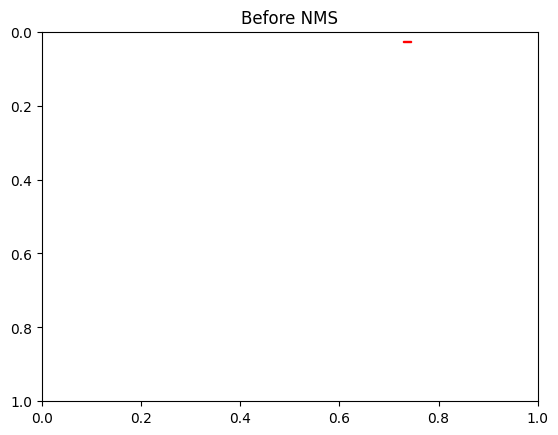

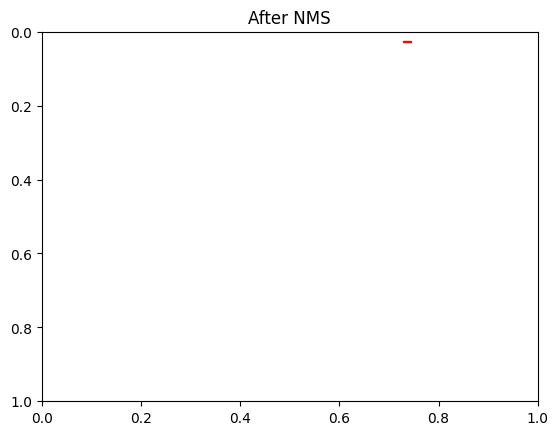

IoU values for current box:  []


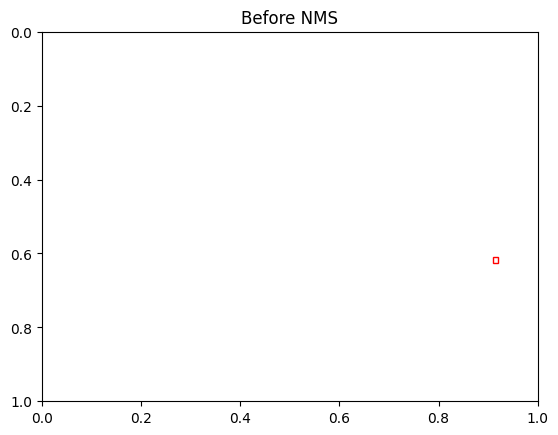

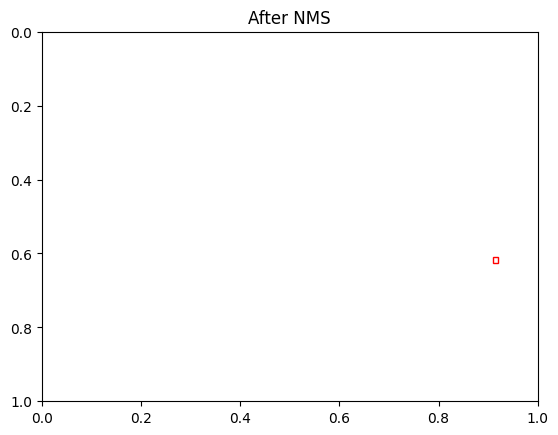

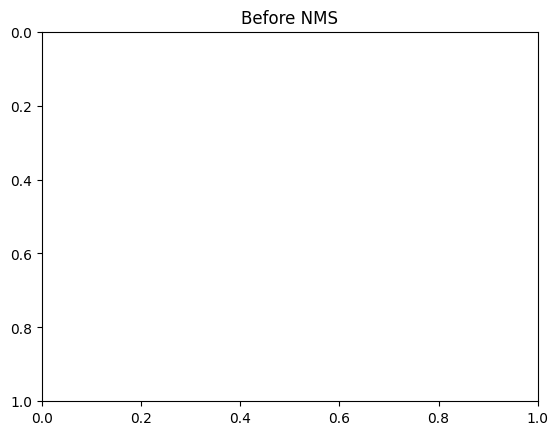

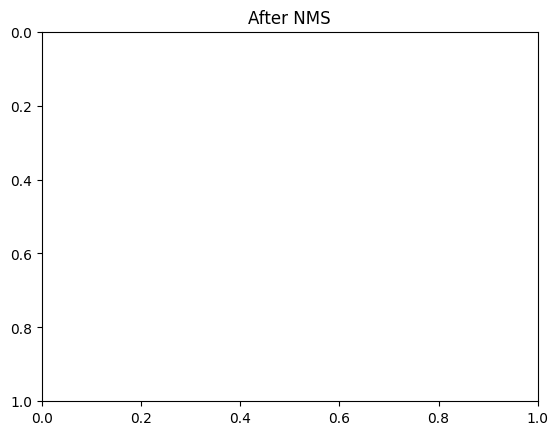

IoU values for current box:  []


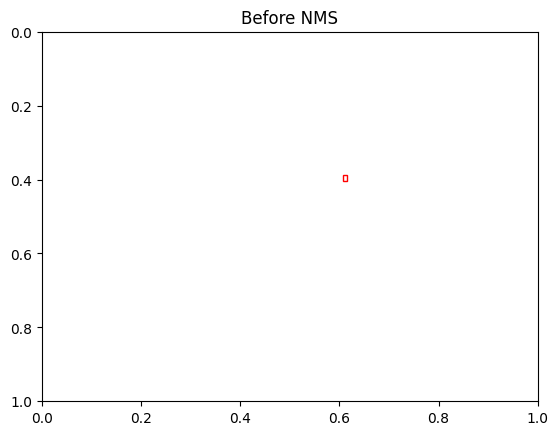

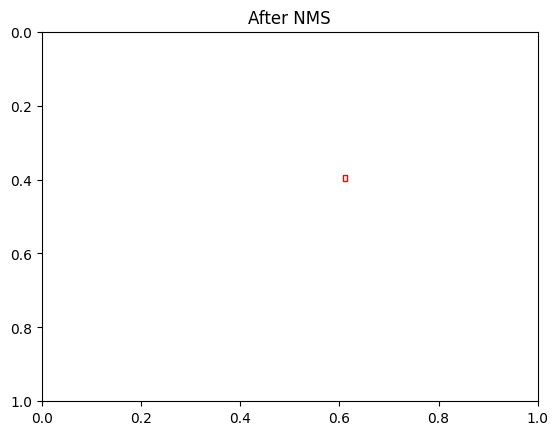

IoU values for current box:  []


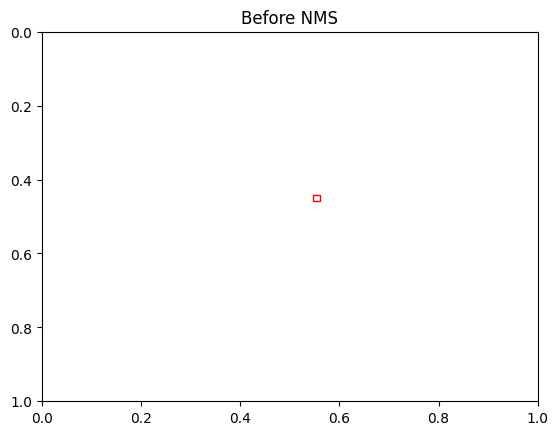

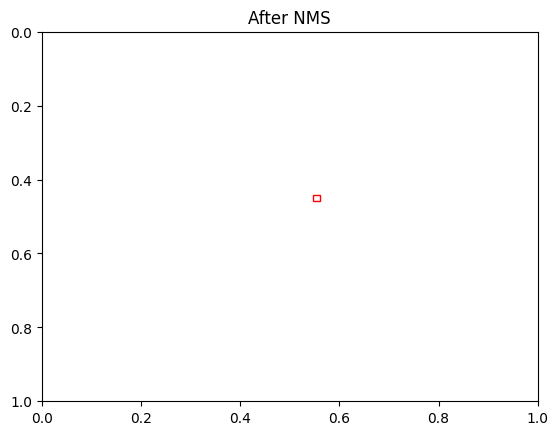

IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  []
IoU values for current box:  [0.]
IoU values for current box: 

In [93]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_boxes_on_image(boxes, title="Boxes on Image"):
    fig, ax = plt.subplots(1)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # Invert y axis to match image coordinates
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.title(title)
    plt.show()

# Example usage within your loop
for i in range(len(output[0])):
    confidences = output[0][i, 0, :, 0]
    newboxes = output[1][i, 0, :, :]

    high_conf_indices = confidences > 0.2  # Adjust the threshold as needed
    confidences = confidences[high_conf_indices]
    newboxes = newboxes[high_conf_indices, :]

    filtered_boxes, _ = non_max_suppression(newboxes, confidences, iou_threshold=0.2)

    if i < 5:  # Limiting to the first 5 examples for visualization
        plot_boxes_on_image(newboxes, "Before NMS")
        plot_boxes_on_image(filtered_boxes, "After NMS")


In [94]:
  
from skimage.measure import label

# Assuming binary_prediction_masks is a list of binary masks for the predictions
labeled_pred_masks = [label(mask) for mask in binary_prediction_masks]

# Assuming binary_ground_truth_masks is a list of binary masks for the ground truth
labeled_gt_masks = [label(mask) for mask in binary_ground_truth_masks]


In [95]:
def evaluate_model(labeled_pred_masks, labeled_gt_masks, iou_threshold=0.3):
    TP = 0
    FP = 0
    FN = 0

    for gt_mask in labeled_gt_masks:
        matched = False
        for pred_mask in labeled_pred_masks:
            iou = compute_iou(pred_mask, gt_mask)
            if iou >= iou_threshold:
                TP += 1
                matched = True
                break
        if not matched:
            FN += 1

    for pred_mask in labeled_pred_masks:
        if not any(compute_iou(pred_mask, gt_mask) >= iou_threshold for gt_mask in labeled_gt_masks):
            FP += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {"Precision": precision, "Recall": recall, "F1 Score": f1_score}

# Example of calling the evaluate_model function
results = evaluate_model(labeled_pred_masks, labeled_gt_masks)
print(f"Precision: {results['Precision']}")
print(f"Recall: {results['Recall']}")
print(f"F1 Score: {results['F1 Score']}")



Precision: 0.012048192771084338
Recall: 0.08571428571428572
F1 Score: 0.021126760563380285


In [69]:
# from skimage.measure import label

# # Assuming binary_prediction_masks is a list of binary masks for the predictions
# labeled_pred_masks = [label(mask) for mask in binary_prediction_masks]

# # Assuming binary_ground_truth_masks is a list of binary masks for the ground truth
# labeled_gt_masks = [label(mask) for mask in binary_ground_truth_masks]


In [10]:

# from skimage.metrics import structural_similarity as ssim

# def match_components(labeled_pred, labeled_gt):
#     matches = []
#     for pred_label in np.unique(labeled_pred)[1:]:  # Skip the background label '0'
#         pred_mask = labeled_pred == pred_label
#         for gt_label in np.unique(labeled_gt)[1:]:
#             gt_mask = labeled_gt == gt_label
#             iou = compute_iou(pred_mask, gt_mask)
#             if iou > 0.5:  # IoU threshold
#                 matches.append((pred_label, gt_label))
#                 break  # Assuming one-to-one matching
#     return matches



# matches = match_components(labeled_pred_masks, labeled_gt_masks)






3) Compute IoU and Find Matches

In [102]:
# def compute_iou(mask1, mask2):
#     intersection = np.logical_and(mask1, mask2).sum()
#     union = np.logical_or(mask1, mask2).sum()
#     iou = intersection / union if union != 0 else 0
# #     return iou

def find_matches(labeled_pred_masks, labeled_gt_masks, threshold=0.2):  # Lowered threshold for testing
    matches = []
    for i, pred_mask in enumerate(labeled_pred_masks):
        for j, gt_mask in enumerate(labeled_gt_masks):
            iou = compute_iou(pred_mask, gt_mask)
            if iou > threshold:
                matches.append((i, j))
                print(f"Match found between prediction {i} and ground truth {j} with IoU: {iou}")  # Debug print
    return matches

# Recalculate matches with debugging and a lower IoU threshold
matches = find_matches(labeled_pred_masks, labeled_gt_masks)
print("Total matches found:", len(matches))


Match found between prediction 7 and ground truth 7 with IoU: 0.5
Match found between prediction 13 and ground truth 13 with IoU: 0.38095238095238093
Match found between prediction 24 and ground truth 24 with IoU: 0.5
Match found between prediction 39 and ground truth 7 with IoU: 0.5
Match found between prediction 60 and ground truth 60 with IoU: 1.0
Match found between prediction 70 and ground truth 60 with IoU: 0.5
Match found between prediction 95 and ground truth 55 with IoU: 0.3333333333333333
Match found between prediction 408 and ground truth 51 with IoU: 0.25
Match found between prediction 436 and ground truth 13 with IoU: 0.2127659574468085
Match found between prediction 480 and ground truth 41 with IoU: 0.5
Total matches found: 10


In [103]:
# True Positives (TP): Predicted components that match ground truth components
TP = len(matches)

# False Positives (FP): Predicted components that don't match any ground truth component
total_pred_components = len(np.unique(labeled_pred_masks)) - 1  # minus 1 to exclude background
FP = total_pred_components - TP

# False Negatives (FN): Ground truth components that weren't matched by predicted components
total_gt_components = len(np.unique(labeled_gt_masks)) - 1  # minus 1 to exclude background
FN = total_gt_components - TP


Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0


In [104]:
# Print metrics
print(f"Precision: {Precision:.2f}, Recall: {Recall:.2f}, F1 Score: {F1:.2f}")


Precision: 1.11, Recall: 5.00, F1 Score: 1.82


In [105]:
# Debug print the values
print(f"Total Predictions (Components): {total_pred_components}")
print(f"Total Ground Truths (Components): {total_gt_components}")
print(f"True Positives (Matches found): {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")


Total Predictions (Components): 9
Total Ground Truths (Components): 2
True Positives (Matches found): 10
False Positives: -1
False Negatives: -8


In [106]:
print("Total Predictions:", sum(len(np.unique(mask)) - 1 for mask in labeled_pred_masks))
print("Total Ground Truths:", sum(len(np.unique(mask)) - 1 for mask in labeled_gt_masks))
print("Matches Found:", len(matches))


Total Predictions: 1107
Total Ground Truths: 31
Matches Found: 10


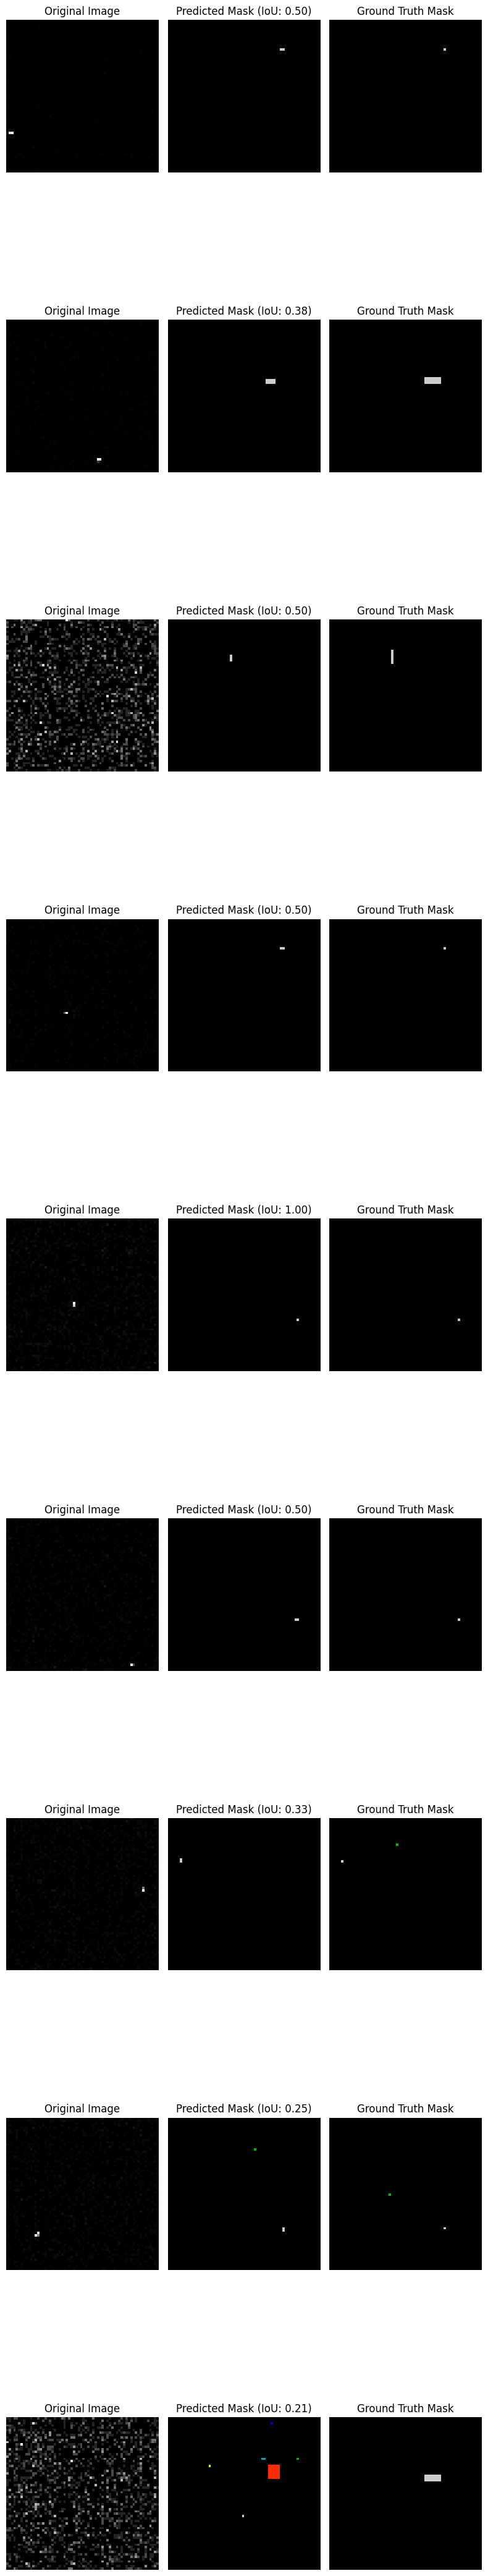

In [107]:
# import matplotlib.pyplot as plt

def visualize_matches(images, labeled_pred_masks, labeled_gt_masks, matches, num_samples=9):
    sample_matches = matches[:num_samples]
    fig, axes = plt.subplots(num_samples, 3, figsize=(8, 5 * num_samples))
    for idx, (pred_index, gt_index) in enumerate(sample_matches):
        axes[idx, 0].imshow(images[idx], cmap='gray')
        axes[idx, 0].set_title('Original Image')
        axes[idx, 1].imshow(labeled_pred_masks[pred_index], cmap='nipy_spectral')
        axes[idx, 1].set_title(f'Predicted Mask (IoU: {compute_iou(labeled_pred_masks[pred_index], labeled_gt_masks[gt_index]):.2f})')
        axes[idx, 2].imshow(labeled_gt_masks[gt_index], cmap='nipy_spectral')
        axes[idx, 2].set_title('Ground Truth Mask')
        for ax in axes[idx]:
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# You need to ensure that the 'matches' are index pairs (pred_index, gt_index) that can be passed to np.random.choice.
# If 'matches' is not a simple array or needs a specific handling for random sampling, adjust the code accordingly.


# Assuming you have an array or list `images` corresponding to the matches
visualize_matches(images_np, tf.convert_to_tensor(labeled_pred_masks), tf.convert_to_tensor(labeled_gt_masks), matches)




In [5]:
# import os

# def create_directory_if_not_exists(directory_path):
#     """
#     Create a directory if it doesn't exist.

#     Args:
#     - directory_path (str): Path of the directory to be created.
#     """
#     if not os.path.exists(directory_path):
#         try:
#             os.makedirs(directory_path)
#             print(f"Directory '{directory_path}' created successfully.")
#         except OSError as e:
#             print(f"Error creating directory '{directory_path}': {e}")
#     else:
#         print(f"Directory '{directory_path}' already exists.")

In [7]:
# import re
# savepath = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationResults/"
# path = "/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationData-20231107T163458Z-001/"
# # savepath = '/home/m3-learning/Documents/myML/ValidationResults/'
# # path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/ValidationData/'

# create_directory_if_not_exists(savepath)

# # Regular expression pattern to match files starting with 'Stack' and ending with '.npz'
# pattern = re.compile(r'^Stack.*\.npz$')

# import time
# start_time = time.time()
# for file in os.listdir(path):
#   if pattern.match(file):
#     general_evaluation(path + file, algorithm = 'fastrcnn_predict', repeat = 1, savepath = savepath, model = loaded_model,
#                       method = 'max',  mode = 'dynamic_window', stride = 64) #meanADU = 1007
#     print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#     start_time = time.time()
# # import time
# start_time = time.time()
# for file in os.listdir(path)[:50]:
#   if file[0] != 'S':
#     continue
#   general_evaluation(path + file,algorithm = 'fastrcnn_predict', repeat = 1, savepath = savepath, model = loaded_model,
#                      method = 'max',  mode = 'dynamic_window', stride = 64) #meanADU = 1007
#   print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#   start_time = time.time()


# import os
# import time
# import tensorflow as tf

# # Assume 'model' is your loaded TensorFlow model, possibly something like:
# # model = tf.keras.models.load_model('path_to_your_model')



# start_time = time.time()
# for file in os.listdir(path)[:50]:
#     if not file.startswith('S'):
#         continue
    
    
#     general_evaluation(os.path.join(path, file), 
#                           algorithm='fastrcnn_predict', 
#                           repeat=1, 
#                           savepath=savepath, 
#                           model=loaded_model,  
#                           method='max', 
#                           mode='dynamic_window', 
#                           stride=64)  # meanADU=1007 may need to be passed inside **kwargs if your function uses it
    
#     print('\nWorked on ', file, 'cost', " %s seconds." % (time.time() - start_time))
#     start_time = time.time()



Directory '/home/m3-learning/Documents/Research Data/Derrick's Object Detection/ValidationResults/' already exists.


In [45]:
# import numpy as np

# file_paths = [
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack007_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack015_result.npz',
#     '/home/m3-learning/Documents/myML/ValidationResults/Stack019_result.npz'

# ]

# # Iterate over each file path to load and print specific metrics
# for file_path in file_paths:
#     data = np.load(file_path)
#     mae = data['mae']
#     precision = data['precision']
#     recall = data['recall']
#     dce = data['dce']
#     dce_corrected = data['dce_corrected']
    
#     print(f"Metrics for {file_path}:")
#     print(f"MAE: {np.mean(mae)}")
#     print(f"Precision: {np.mean(precision)}")
#     print(f"Recall: {np.mean(recall)}")
#     print(f"DCE: {np.mean(dce)}")
#     print(f"DCE Corrected: {np.mean(dce_corrected)}")
#     print("-" * 30)


In [43]:
# import numpy as np

# # def load_data(file_path):
# #     data = np.load(file_path)
# #     return data['result'], data['mae'], data['dce'], data['recall'], data['precision'], data['deviations'], data['dce_corrected']

# def load_data(file_path):
#     """
#     Load data from an NPZ file.
#     """
#     with np.load(file_path, allow_pickle=True) as data:
#         result = data['result']
#         mae = data['mae']
#         dce = data['dce']
#         recall = data['recall']
#         precision = data['precision']
#         deviations = data['deviations']
#         dce_corrected = data['dce_corrected']
#     return result, mae, dce, recall, precision, deviations, dce_corrected

# # Metric Calculation Functions
# def calculate_mae(filtered, ground_truth):
#     return np.mean(np.abs(filtered - ground_truth))

# def calculate_precision(tp, fp):
#     return tp / (tp + fp) if (tp + fp) > 0 else 0

# def calculate_recall(tp, fn):
#     return tp / (tp + fn) if (tp + fn) > 0 else 0

# def calculate_dce(detected_count, actual_count):
#     return detected_count / actual_count if actual_count > 0 else 0

# def calculate_corrected_dce(deviations, actual_count):
#     valid_detections = len([d for d in deviations if d <= 6])  # Example threshold
#     return valid_detections / actual_count if actual_count > 0 else 0

# # Process data and calculate metrics
# # def process_data(file_path):
# #     predictions, ground_truth = load_data(file_path)
# #     metrics = {'mae': [], 'precision': [], 'recall': [], 'dce': [], 'corrected_dce': []}
    
# #     for i in range(predictions.shape[0]):
# #         filtered = predictions[i]
# #         truth = ground_truth[i]

# #         tp = np.sum((filtered > 0) & (truth > 0))
# #         fp = np.sum((filtered > 0) & (truth == 0))
# #         fn = np.sum((filtered == 0) & (truth > 0))
# #         detected_count = np.sum(filtered > 0)
# #         actual_count = np.sum(truth > 0)

# #         mae = calculate_mae(filtered, truth)
# #         precision = calculate_precision(tp, fp)
# #         recall = calculate_recall(tp, fn)
# #         dce = calculate_dce(detected_count, actual_count)
# #         deviations = np.random.uniform(0, 10, size=tp)  # Example deviations, replace with actual
# #         corrected_dce = calculate_corrected_dce(deviations, actual_count)

# #         metrics['mae'].append(mae)
# #         metrics['precision'].append(precision)
# #         metrics['recall'].append(recall)
# #         metrics['dce'].append(dce)
# #         metrics['corrected_dce'].append(corrected_dce)

# #     # Calculate average metrics
# #     for key in metrics:
# #         metrics[key] = np.mean(metrics[key])

# #     return metrics

# # # Example usage
# # file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# # results = process_data(file_path)
# # print(results)

# # def process_data(file_path):
# #     # Load data
# #     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

# #     # Convert to numpy arrays if they are not already
# #     mae = np.array(mae)
# #     dce = np.array(dce)
# #     recall = np.array(recall)
# #     precision = np.array(precision)
# #     dce_corrected = np.array(dce_corrected)

# #     # Calculate average metrics
# #     metrics = {
# #         'Average MAE': np.mean(mae),
# #         'Average DCE': np.mean(dce),
# #         'Average Recall': np.mean(recall),
# #         'Average Precision': np.mean(precision),
# #         'Average Corrected DCE': np.mean(dce_corrected)
# #     }

# #     return metrics

# # Example usage
# # file_path = '/home/m3-learning/Documents/myML/ValidationResults/Stack001_result.npz'
# # results = process_data(file_path)
# # print("Aggregated Metrics:", results)

# def process_data(file_path):
#     """
#     Process the loaded data to calculate average metrics.
#     """
#     # Load results and metrics from the file
#     result, mae, dce, recall, precision, deviations, dce_corrected = load_data(file_path)

#     # Calculate average of each metric
#     metrics = {
#         'Average MAE': np.mean(mae),
#         'Average DCE': np.mean(dce),
#         'Average Recall': np.mean(recall),
#         'Average Precision': np.mean(precision),
#         'Average Corrected DCE': np.mean(dce_corrected)
#     }

#     return metrics

# def print_results(metrics):
#     """
#     Print the calculated average metrics.
#     """
#     for metric_name, average_value in metrics.items():
#         print(f"{metric_name}: {average_value:.4f}")

# # Main function to run the script
# def main():
#     file_path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/ValidationData/Stack007.npz'  # Update this to your actual file path
#     results = process_data(file_path)
#     print_results(results)

# if __name__ == "__main__":
#     main()

KeyError: 'result is not a file in the archive'

In [44]:
def inspect_npz_file(file_path):
    with np.load(file_path) as data:
        print("Keys in the NPZ file:", list(data.keys()))

# Example usage
file_path = '/home/m3-learning/Documents/myML/ValidationData-20231107T163458Z-001/ValidationData/Stack007.npz'
inspect_npz_file(file_path)


Keys in the NPZ file: ['X', 'y', 'sparsitymin', 'sparsitymax']


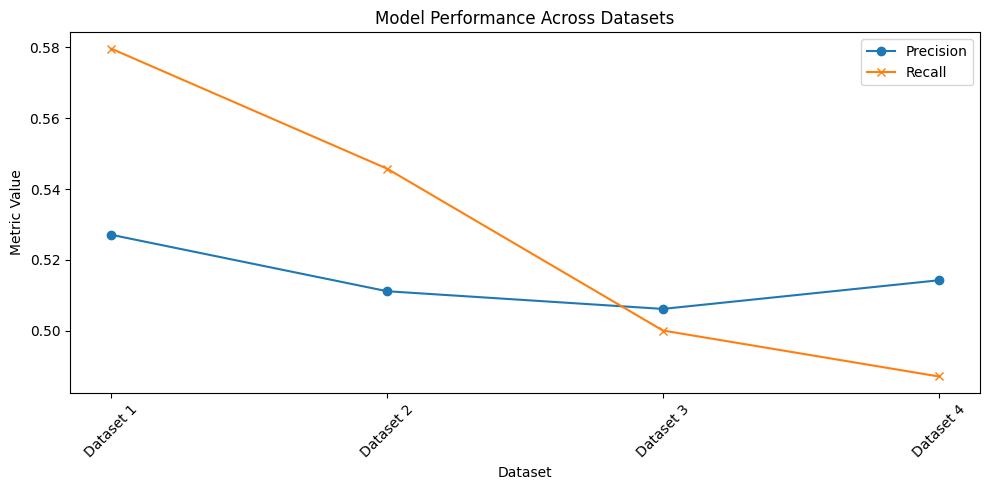

In [14]:
import matplotlib.pyplot as plt


precisions = []
recalls = []

for file_path in file_paths:
    data = np.load(file_path)
    precisions.append(np.mean(data['precision']))
    recalls.append(np.mean(data['recall']))

# Simple plot of precision and recall
plt.figure(figsize=(10, 5))
plt.plot(precisions, label='Precision', marker='o')
plt.plot(recalls, label='Recall', marker='x')
plt.title('Model Performance Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Metric Value')
plt.legend()
plt.xticks(range(len(file_paths)), labels=[f"Dataset {i+1}" for i in range(len(file_paths))], rotation=45)
plt.tight_layout()
plt.show()
